# We are going to start teaching rasterio data processing using rioxarray.

Learning Objectives
- Open, plot, and explore raster data using Python.
- Handle no data values in raster data.
- Create plotting extents so you can plot raster and vector data together using matplotlib.
- Explore raster data using histograms and descriptive statistics.

In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [2]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

You then open the data using **rio.open("path-to-raster-here").**

In [4]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

When you open raster data using rasterio you are creating a numpy array. Numpy is an efficient way to work with and process raster format data. You can plot your data using earthpy plot_bands() which takes a numpy array as an input and generates a plot.

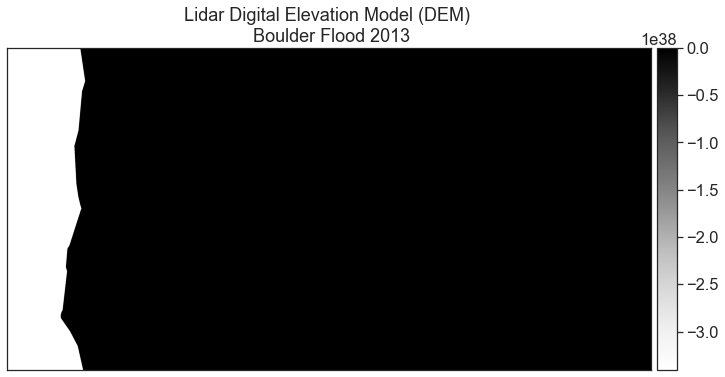

In [5]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below you check out the min and max values of the data.



In [6]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


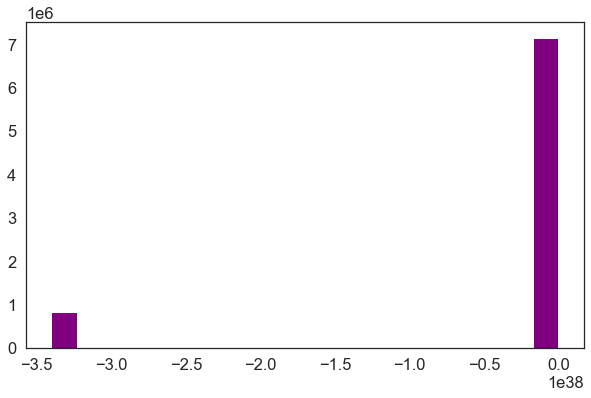

In [7]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

## Raster Data Exploration - Min and Max Values
Looking at the minimum value of the data, there is one of two things going on that need to be fixed

- there may be no data values in the data with a negative value that are skewing your plot colors
- there also could be outlier data in your raster

You can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, you will use the masked=True parameter for the .read() function - like this:

dem_src.read(1, masked=True)

In [8]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)#masking no data values using rasterio.

In [9]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43


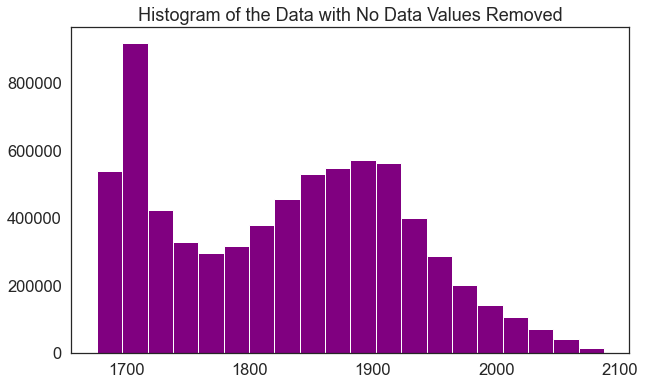

In [10]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
        figsize=(10, 6),
        title="Histogram of the Data with No Data Values Removed")
plt.show()

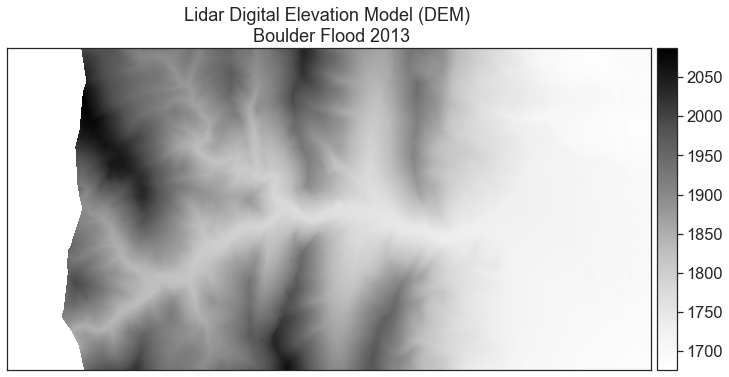

In [11]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

## Rasterio Reads Files into Python as Numpy Arrays
When you call src.read() above, rasterio is reading in the data as a **numpy array**. A numpy array is a matrix of values. Numpy arrays are an efficient structure for working with large and potentially multi-dimensional (layered) matrices.

The numpy array below is type numpy.ma.core.MaskedArray. It is a masked array because you chose to mask the no data values in your data. Masking ensures that when you plot and perform other math operations on your data, those no data values are not included in the operations.

Data Tip: If you want to learn more about Numpy arrays, check out the intro to earth datascience textbook chapter on Numpy arrays.

In [12]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


## Spatial metadata

A numpy array does not by default store spatial information. However, your raster data is spatial - it represents a location on the earth’s surface.

You can acccess the **spatial metadata** within the context manager using **dem_src.profile**. Notice that the .profile object contains information including the no data values for your data, the shape, the file type and even the coordinate reference system. 

In [13]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## Context Managers to Open and Close File Connections
The steps above represent the steps you need to open and plot a raster dataset using rasterio in python. The with rio.open() statement creates what is known as a context manager. A context manager allows you to open the data and work with it. Within the context manager, Python makes a temporary connection to the file that you are trying to open.

In the example above this was a file called pre_DTM.tif.

To break this code down, the context manager has a few parts. First, it has a with statement. The with statement creates a connection to the file that you want to open. The default connection type is read only. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

with rio.open(`file-path-here`) as file_src:

       dtm_pre_arr = dem_src.read(1, masked=True)

Notice that the first line of the context manager is not indented. It contains two parts

- rio.open(): This is the code that will open a connection to your .tif file using a path you provide.
- file_src: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

    The second line of your with statement

dtm_pre_arr = dem_src.read(1, masked=True)

is indented. Any code that is indented directly below the with statement will become a part of the context manager. This code has direct access to the file_src object which is you recall above is the rasterio reader object.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once you are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in your code.

You can get a better understanding of how the rasterio context manager works by taking a look at what it is doing line by line. Start by looking at the dem_pre_path object. Notice that this object is a path to the file pre_DEM.tif. The context manager needs to know where the file is that you want to open with Rasterio.

In [15]:
# Look at the path to your dem_pre file
dem_pre_path

'colorado-flood\\spatial\\boulder-leehill-rd\\pre-flood\\lidar\\pre_DTM.tif'

Now use the dem_pre_path in the context manager to open and close your connection to the file. Notice that if you print the “src” object within the context manager (notice that the print statement is indented which is how you know that you are inside the context manager), the returl is an

open DatasetReader

The name of the reader is the path to your file. This means there is an open and active connection to the file.

In [16]:
# Opening the file with the dem_pre_path
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood\spatial\boulder-leehill-rd\pre-flood\lidar\pre_DTM.tif' mode='r'>


If you print that same src object outside of the context manager, notice that it is now a closed datasetReader object. It is closed because it is being called outside of the context manager. Once the connection is closed, you can no longer access the data. This is a good thing as it protects you from inadvertently modifying the file itself!

In [17]:
# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<closed DatasetReader name='colorado-flood\spatial\boulder-leehill-rd\pre-flood\lidar\pre_DTM.tif' mode='r'>


Now look at what .read() does. Below you use the context manager to both open the file and read it. See that the read() method, returns a numpy array that contains the raster cell values in your file.

In [20]:
# Open the file using a context manager and get the values as a numpy array with .read()
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)



Because you created an object within the context manager that contains those raster values as a numpy array, you can now access the data values without needing to have an open connection to your file. This ensures once again that you are not modifying your original file and that all connections to it are closed. You are now free to play with the numpy array and process your data!

In [19]:
# View numpy array of your data
dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

You can use the .profile attribute to create an object with metadata on your raster image. The metadata object below contains information like the coordinate reference system and size of the raster image.

In [21]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

Finally, take a look at what the plotting_extent() function does. Note below that when you run the plotting_extent() function on your dem_pre raster image, you get the extent of the image as an output.

In [22]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_plot_ext that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

# Plot Raster and Vector Data Together: Plot Extents
Numpy arrays are an efficient way to store and process data. However, by default they do not contain spatial information. To plot raster and vector data together on a map, you will need to create an extent object that defines the spatial extent of your raster layer. This will then allow you to plot a raster and vector data together to create a map.

Below you open a single shapefile that contains a boundary layer that you can overlay on top of your raster dataset.

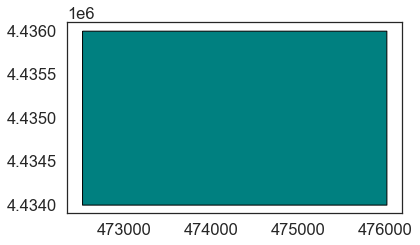

In [24]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()

You can try to plot the two datasets together but you will see below that the output plot does not look correct. This is because the raster layer has no spatial information associated with it.

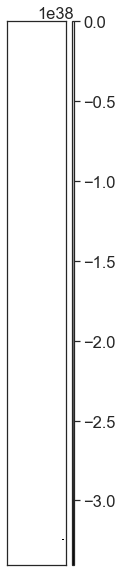

In [26]:
fig, ax = plt.subplots(figsize=(4, 10))

ep.plot_bands(dtm_pre_arr, ax=ax)

site_bound_shp.plot(color='teal',
                    edgecolor='black', ax=ax)

plt.show()

When you try to plot a raster and vector together with out a plotting extent defined for the raster layer, you often get a plot like this. Notice that the plot looks blank and does not show the raster layer that you know plotted ok above.

In [27]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_plot_ext that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

Next try to plot. This time however, use the extent= parameter to specify the plotting extent within ep.plot_bands()

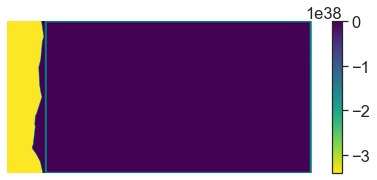

In [31]:
fig, ax = plt.subplots()

ep.plot_bands(dtm_pre_arr,
              cmap = 'viridis_r',
              ax=ax,
              extent=lidar_dem_plot_ext) #extent evita 1d

site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)
# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()